Authors: 
   <br> Qintai Liu  (ql819)
    <br>Yi Deng (yd1055)
    <br>Shuangjin Zhang (sz1829)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import itertools
from sklearn.pipeline import Pipeline 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve,auc
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
import matplotlib.gridspec as gridspec
from sklearn.metrics import precision_score


In [2]:
def getRelativeChangeInSerachVolume(n=1):
    '''This function will wirte all of the csv files in the ./data/words/
    dictory each of which contains the relative search volume of a specfic
    word in the past 5 years. And then calculate the relative change
    in search volume in n week '''
    
    
    path = './data/words/'
    
    for file in os.listdir(path):
        if (file.split('.')[-1])!= 'csv':
            continue
        filePath = path+file
        #print(filePath)
        df = pd.read_csv(filePath,header=1,index_col=0)
        df.index = pd.to_datetime(df.index).to_period('w')
        word = df.columns.values[0].split(':')[0]
        df.rename(columns={df.columns.values[0]:word},inplace=True)
        for i in range(1,n+1):
            df['previous {}th week'.format(i)] = df[word].shift(i)
        df.dropna(inplace=True)
        df['{}:Relative Change'.format(word)] = df[word] - np.mean(df.iloc[:,1:],axis=1)
        df = df.iloc[:,[-1]]
        try: result
        except NameError: result=df.copy()
        else:
            result = result.merge(df,how='outer',left_index=True,right_index=True)
    return result.dropna().iloc[:-1,:]

In [3]:
def getBestEstimator(grid_search_A,grid_search_B):
    '''This function will take two parameters, each of which is a fitted
    gridsearch result. The function will compare the best estimator in 
    gridsearch_A and gridsearch_B in terms of the mean of the accuracy, and then output the best estimator'''
    result_A = grid_search_A.cv_results_
    result_B = grid_search_B.cv_results_
    best_id_A = np.argmin(result_A['rank_test_Accuracy'])
    best_score_A = result_A['mean_test_Accuracy'][best_id_A]
    best_id_B = np.argmin(result_B['rank_test_Accuracy'])
    best_score_B = result_B['mean_test_Accuracy'][best_id_B]
    if best_score_A >= best_score_B:
        return grid_search_A.best_estimator_
    else:
        return grid_search_B.best_estimator_

In [4]:
def drawGridSearchCVResult(results,title=None,xlabel=None,X_axis=None,legends=None):
    '''This function will draw the result from two fitted GridSearch. There
    are two scoring method to measure the performance of a estimator, which is
    accuracy rate and recall. Each of the score is calculated by the mean of the score
    of each different splits (cv=5) and meanwhile the std will be calculated. 
    Finally, a area between [mean-std,mean+std] will be drawn for each estimator'''
    
    
    plt.figure(figsize=(10, 10))
    plt.title(title,fontsize=16)
    plt.xlabel(xlabel)
    plt.ylabel("Score")
    plt.grid()
    ax = plt.axes()
    plt.ylim(0.3,1.02)
    X_axis = X_axis
    scoring = {'Recall': 'recall', 'Accuracy':'accuracy'}
    for result,kind,colors in zip(results,legends,[['b', 'k'],['g', 'r']]):
        for scorer, color in zip(sorted(scoring), colors):
            for sample, style in (('train', '--'), ('test', '-')):
                sample_score_mean = result['mean_%s_%s' % (sample, scorer)]
                sample_score_std = result['std_%s_%s' % (sample, scorer)]
                ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,alpha=0.1 if sample == 'test' else 0, color=color)
                ax.plot(X_axis, sample_score_mean, style, color=color,
                    alpha=1 if sample == 'test' else 0.7,
                    label="%s %s (%s)" % (kind,scorer, sample))
            best_index = np.nonzero(result['rank_test_%s' % scorer] == 1)[0][0]
            best_score = result['mean_test_%s' % scorer][best_index]
            # Plot a dotted vertical line at the best score for that scorer marked by x
            ax.plot([X_axis[best_index], ] * 2, [0, best_score],
                linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)
            # Annotate the best score for that scorer
            ax.annotate("%0.2f" % best_score,
                    (X_axis[best_index], best_score + 0.005))
    plt.legend(loc="best")
    plt.grid('off')
    plt.show()            

In [5]:
def GridSearchSVM(X_train,Y_train):
    '''This function will exhaustivly search over specified parameter values (C) for 
    a SVM estimator whoes kernel is either poly or rbf. Then the function drawGridSearchCVResult
    will be called to visualize the perfomances (accuracy and recall) for each 
    SVM with specific value C. Then calling the getBestEstimator function to return the
    best SVM estimator'''
    
    
    pipe = Pipeline([('preprocess',preprocessing.StandardScaler()),('clf',SVC())])
    C = np.array([0.001, 0.01, 0.1, 1, 10, 100, 1000])
    param_grid = {'preprocess':[preprocessing.StandardScaler()],
             'clf__C': C,
             'clf__kernel':['poly']}
    scoring = {'Recall': 'recall', 'Accuracy':'accuracy'}
    grid_search_svm_poly = GridSearchCV(pipe, param_grid=param_grid,cv=5,scoring=scoring,
                          refit='Accuracy',n_jobs=100)
    grid_search_svm_poly.fit(X_train,Y_train)
    result_poly = grid_search_svm_poly.cv_results_

    pipe = Pipeline([('preprocess',preprocessing.StandardScaler()),('clf',SVC())])
    param_grid = {'preprocess':[preprocessing.StandardScaler()],
             'clf__C': C,
             'clf__kernel':['rbf']}
    grid_search_svm_rbf = GridSearchCV(pipe, param_grid=param_grid,cv=5,scoring=scoring,
                          refit='Accuracy',n_jobs=100)
    grid_search_svm_rbf.fit(X_train,Y_train)
    result_rbf = grid_search_svm_rbf.cv_results_
    drawGridSearchCVResult(results = [result_poly,result_rbf],title = 'SVM GridSearch evaluationusing accuracy and recall',xlabel='log10 penalty C', X_axis=np.log10(C),
                       legends=['SVM poly','SVM rbf'])
    return getBestEstimator(grid_search_svm_poly,grid_search_svm_rbf)

In [6]:
def GridSearchRandomForest(X_train,Y_train):
    '''This function will exhaustivly search over specified parameter values (min_samples_split) for 
    a RandomForest estimator whoes max_features is either sqrt(n_features)  or n_features. 
    Then the function drawGridSearchCVResult will be called to visualize the perfomances (accuracy and recall) 
    for each RandomForest with specific value min_samples_split. Then calling the getBestEstimator function 
    to return the best RandomForest estimator'''
    
    
    rng = range(2,6,1)
    param_grid = {'max_features':['sqrt'],
                 'min_samples_split': rng}
    scoring = {'Recall': 'recall', 'Accuracy':'accuracy'}
    grid_search_sqrt = GridSearchCV(RandomForestClassifier(n_estimators=1000), param_grid=param_grid,cv=5,scoring=scoring,
                          refit='Accuracy',n_jobs=100)
    grid_search_sqrt.fit(X_train,Y_train)
    result_sqrt = grid_search_sqrt.cv_results_

    param_grid = {'max_features':[None],
             'min_samples_split': rng}
    grid_search_None = GridSearchCV(RandomForestClassifier(n_estimators=1000), param_grid=param_grid,cv=5,scoring=scoring,
                          refit='Accuracy',n_jobs=100)
    grid_search_None.fit(X_train,Y_train)
    result_None = grid_search_None.cv_results_
    drawGridSearchCVResult(results = [result_sqrt,result_None],title =
                           'RandomForest GridSearch evaluation using accuracy and recall',xlabel='min_samples_split', X_axis=rng,
                           legends=['sqrt features sqrt','all features'])
    return getBestEstimator(grid_search_sqrt,grid_search_None)

In [7]:
def GridSearchLogisticRegression(X_train,Y_train):
    '''This function will exhaustivly search over specified parameter values (C) for 
    a LogisticRegression estimator whoes penalty is either 'l1' or 'l2'. 
    Then the function drawGridSearchCVResult will be called to visualize the perfomances (accuracy and recall) 
    for each LogisticRegression with specific value C. Then calling the getBestEstimator function 
    to return the best LogisticRegression estimator'''
    
    
    C = np.array([0.001, 0.01, 0.1, 1, 10, 100, 1000])
    param_grid = {'C': C}
    scoring = {'Recall': 'recall', 'Accuracy':'accuracy'}
    grid_search_l_1 = GridSearchCV(LogisticRegression(penalty='l1'), param_grid=param_grid,cv=5,scoring=scoring,
                          refit='Accuracy',n_jobs=100)
    grid_search_l_1.fit(X_train,Y_train)
    result_l_1 = grid_search_l_1.cv_results_


    param_grid = {'C': C}
    grid_search_l_2 = GridSearchCV(LogisticRegression(penalty='l2'), param_grid=param_grid,cv=5,scoring=scoring,
                          refit='Accuracy',n_jobs=100)
    grid_search_l_2.fit(X_train,Y_train)
    result_l_2 = grid_search_l_2.cv_results_
    drawGridSearchCVResult(results = [result_l_1,result_l_2],title = 'LogisticRegression GridSearch evaluation using accuracy and recall',
                           xlabel='log10 penalty C', X_axis=np.log10(C),legends=['penalty=l1 ','penalty=l2 '])
    return getBestEstimator(grid_search_l_1,grid_search_l_2)


In [8]:
def drawBestCLF(best_clf_svm,best_clf_rf,best_clf_lr,skf,X_train,Y_train,t):
    '''This function take the best estimator for SVM, RandomForest and LogisticRegression
     Then run cross validation (cv=5) for each best estimator and visualize the 
     performance (accuracy rate) for each estimator'''
    
    result_svm = cross_val_score(best_clf_svm,X_train,Y_train,cv=skf)
    result_rf = cross_val_score(best_clf_rf,X_train,Y_train,cv=skf)
    result_lr = cross_val_score(best_clf_lr,X_train,Y_train,cv=skf)
    plt.figure(figsize=(8, 8))
    plt.title('For Δt={}, Evaluate the best estimator for each model by CV '.format(t))
    plt.xlabel('ith fold')
    plt.ylabel('accuracy')
    plt.plot(range(0,10),result_svm,'r-',label="SVM mean:%0.2f std:%0.2f" % (np.mean(result_svm),np.std(result_svm)))
    plt.plot(range(0,10),result_rf,'b-',label="RandomForest mean:%0.2f std:%0.2f" % (np.mean(result_rf),np.std(result_rf)))
    plt.plot(range(0,10),result_lr,'g-',label="LogisticRegression mean:%0.2f std:%0.2f" % (np.mean(result_lr),np.std(result_lr)))
    plt.legend()
    plt.show()

In [9]:

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """

    

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    



<h1>Explore the data set</h1>
First, bulid a dataframe containing relative search volumne change for each word in Δt = 3 weeks

In [10]:
result = getRelativeChangeInSerachVolume(3)
print(result.shape)
result.head()

(255, 44)


,housing:Relative Change,leverage:Relative Change,fun:Relative Change,loss:Relative Change,debt:Relative Change,society:Relative Change,profit:Relative Change,cancer:Relative Change,growth:Relative Change,bonds:Relative Change,...,portfolio:Relative Change,money:Relative Change,revenue:Relative Change,economics:Relative Change,office:Relative Change,cash:Relative Change,ring:Relative Change,religion:Relative Change,inflation:Relative Change,hedge:Relative Change
Week,,,,,,,,,,,,,,,,,,,,,
2012-12-17/2012-12-23,-11.666667,63.333333,4.000000,-1.333333,-9.666667,-13.333333,-22.333333,-10.000000,-17.000000,-27.000000,...,-25.333333,-1.333333,-17.000000,-41.666667,-10.333333,-1.666667,12.333333,-18.666667,-20.333333,-7.000000
2012-12-24/2012-12-30,9.333333,-15.000000,2.000000,15.333333,12.000000,-1.333333,-2.000000,-1.333333,-0.333333,-10.333333,...,-3.666667,3.666667,1.666667,-13.000000,-0.333333,0.333333,-5.333333,-17.666667,-4.333333,0.333333
2012-12-31/2013-01-06,18.666667,-31.333333,-0.333333,12.000000,9.000000,9.333333,15.000000,10.333333,10.000000,15.000000,...,15.000000,4.000000,13.666667,26.666667,7.666667,-0.333333,-11.000000,0.666667,6.666667,4.333333
2013-01-07/2013-01-13,9.666667,-31.666667,-1.666667,1.666667,10.666667,8.333333,13.333333,8.333333,9.666667,13.333333,...,12.000000,1.000000,16.666667,30.000000,4.000000,-1.333333,-9.333333,6.000000,10.666667,4.333333
2013-01-14/2013-01-20,4.000000,-9.666667,-3.000000,-1.333333,-2.333333,2.333333,7.333333,0.666667,5.666667,-0.333333,...,1.333333,-0.333333,8.333333,11.333333,2.333333,0.000000,2.333333,6.333333,3.000000,-0.333333


<h2>Read historical data about S&P500 in the past 5 years with weekly frequency</h2>

In [11]:
spx = pd.read_csv('./data/spx.csv',index_col=0)
spx.index = pd.to_datetime(spx.index).to_period('w')
spx['change'] = (spx['Close']-spx['Close'].shift(1))
spx['decrease'] = (spx['change'] <0).astype('int')
spx.dropna(inplace=True)
spx.head()

,Open,High,Low,Close,Adj Close,Volume,change,decrease
Date,,,,,,,,
2012-12-03/2012-12-09,1416.339966,1423.729980,1398.229980,1418.069946,1418.069946,16930770000,1.889892,0
2012-12-10/2012-12-16,1418.069946,1438.589966,1411.880005,1413.579956,1413.579956,16918840000,-4.489990,1
2012-12-17/2012-12-23,1413.540039,1448.000000,1413.540039,1430.150024,1430.150024,20543390000,16.570068,0
2012-12-24/2012-12-30,1430.150024,1430.150024,1401.579956,1402.430054,1402.430054,8790850000,-27.719970,1
2012-12-31/2013-01-06,1402.430054,1467.939941,1398.109985,1466.469971,1466.469971,14660950000,64.039917,0


In [12]:
spx[['decrease']].groupby('decrease').agg({'decrease':'count'})

,decrease
decrease,
0,158
1,103


In [13]:
#combine result with sp500
data = result.merge(spx[['decrease']],left_index=True,right_index=True)
data.head(4)

,housing:Relative Change,leverage:Relative Change,fun:Relative Change,loss:Relative Change,debt:Relative Change,society:Relative Change,profit:Relative Change,cancer:Relative Change,growth:Relative Change,bonds:Relative Change,...,money:Relative Change,revenue:Relative Change,economics:Relative Change,office:Relative Change,cash:Relative Change,ring:Relative Change,religion:Relative Change,inflation:Relative Change,hedge:Relative Change,decrease
Week,,,,,,,,,,,,,,,,,,,,,
2012-12-17/2012-12-23,-11.666667,63.333333,4.000000,-1.333333,-9.666667,-13.333333,-22.333333,-10.000000,-17.000000,-27.000000,...,-1.333333,-17.000000,-41.666667,-10.333333,-1.666667,12.333333,-18.666667,-20.333333,-7.000000,0
2012-12-24/2012-12-30,9.333333,-15.000000,2.000000,15.333333,12.000000,-1.333333,-2.000000,-1.333333,-0.333333,-10.333333,...,3.666667,1.666667,-13.000000,-0.333333,0.333333,-5.333333,-17.666667,-4.333333,0.333333,1
2012-12-31/2013-01-06,18.666667,-31.333333,-0.333333,12.000000,9.000000,9.333333,15.000000,10.333333,10.000000,15.000000,...,4.000000,13.666667,26.666667,7.666667,-0.333333,-11.000000,0.666667,6.666667,4.333333,0
2013-01-07/2013-01-13,9.666667,-31.666667,-1.666667,1.666667,10.666667,8.333333,13.333333,8.333333,9.666667,13.333333,...,1.000000,16.666667,30.000000,4.000000,-1.333333,-9.333333,6.000000,10.666667,4.333333,0


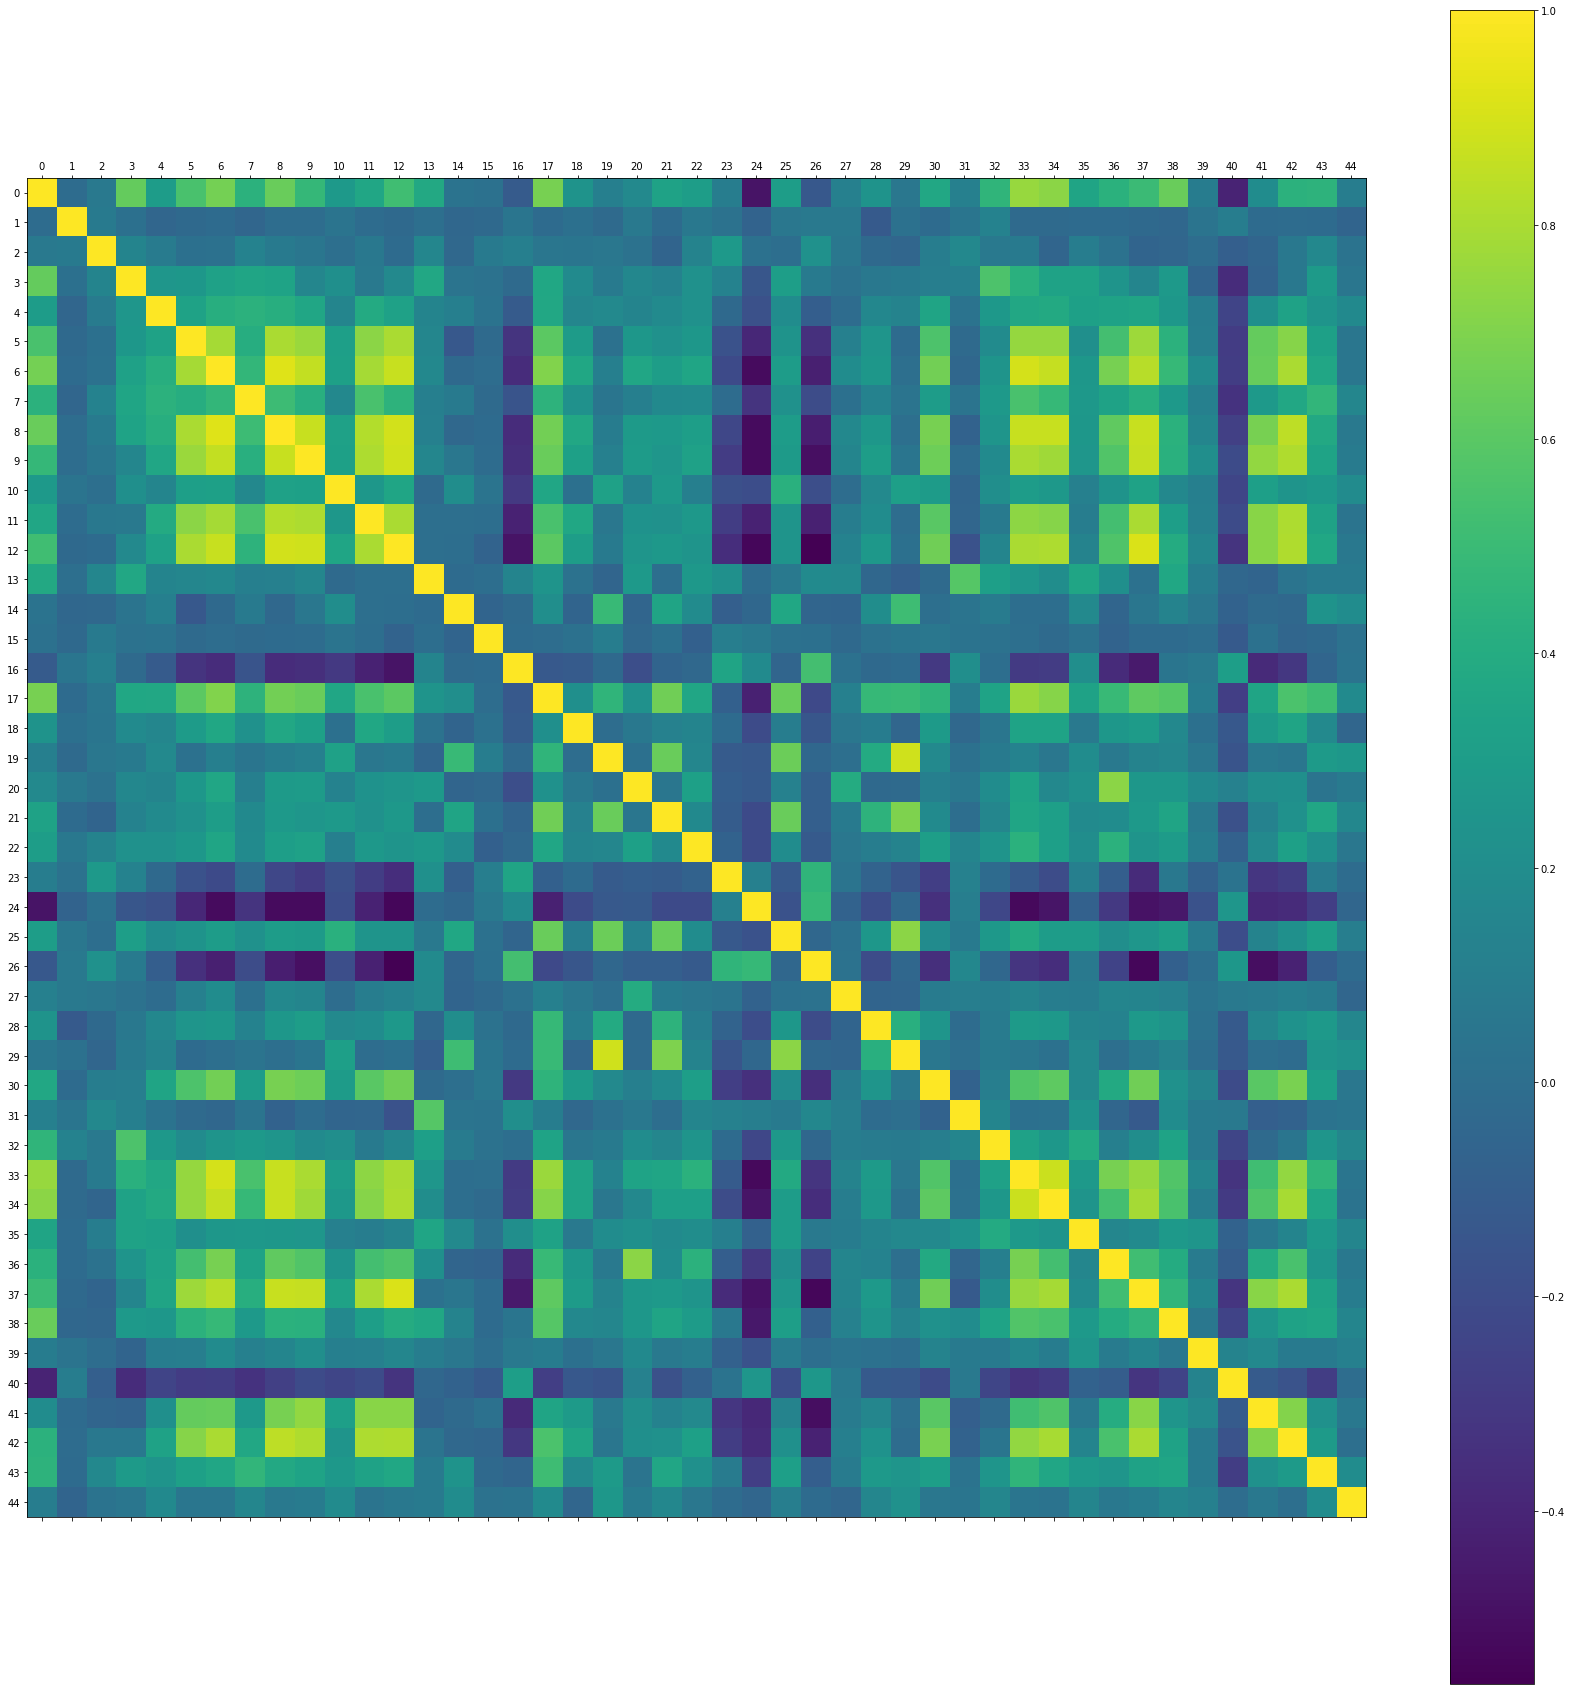

In [14]:
plt.close()
corrcoef = np.corrcoef(data,rowvar=False)
fig = plt.gcf()
fig.set_size_inches(30,30)
cax = plt.matshow(corrcoef,fignum=1)
plt.colorbar(cax)
ticks = np.arange(0,corrcoef.shape[0])
plt.xticks(ticks)
plt.yticks(ticks)
plt.show()

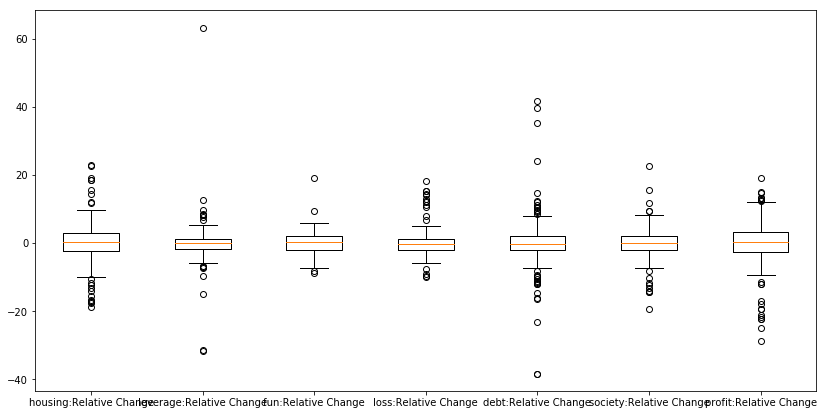

In [15]:
columns = data.columns.tolist()[:-1]
draw_data = [data[column] for column in columns[:7]]
plt.figure(figsize=(14,7))
plt.boxplot(draw_data,labels=columns[:7])
plt.show()

As the can see from the boxplot, there are some extreme outliers existing in the data

<h1>Δt = 1, find the best model</h1>

First bulid the dataset which is used to fit the model

In [16]:
skf = KFold(n_splits=10,random_state=2)
result = getRelativeChangeInSerachVolume(1)
data = result.merge(spx[['decrease']],left_index=True,right_index=True)
X_1_train, Y_1_train = data.iloc[:,:-1], data['decrease']

When Δt = 1, tune the parameters(C=[0.001, 0.01, 0.1, 1, 10, 100, 1000],kernel=['poly','rbf']) for SVM

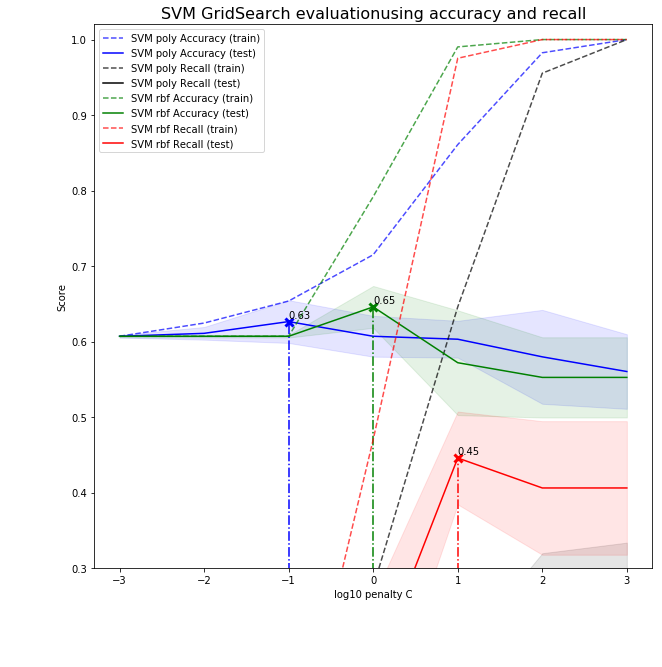

In [17]:

best_clf_svm = GridSearchSVM(X_1_train,Y_1_train)

When Δt = 1, tune the parameters(max_features:['sqrt','None'],min_samples_split:[2,3,4,5]) for RandomForest

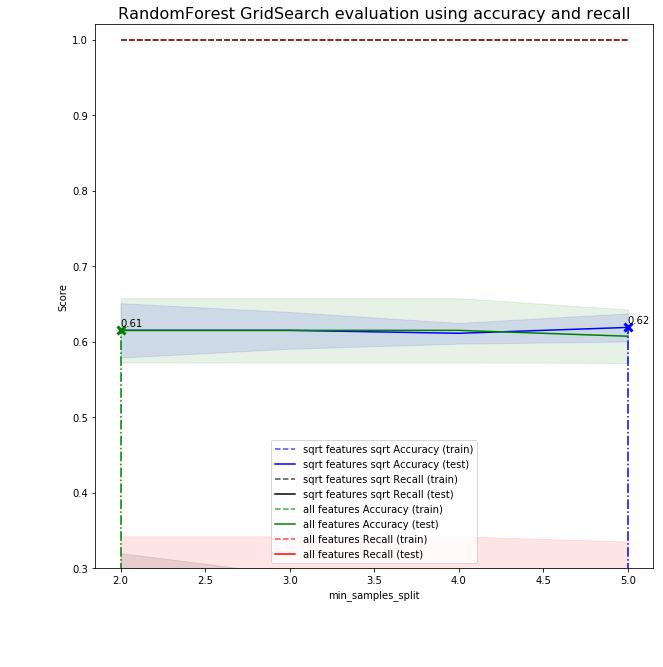

In [18]:
best_clf_rf = GridSearchRandomForest(X_1_train,Y_1_train)

When Δt = 1, tune the parameters(C=[0.001, 0.01, 0.1, 1, 10, 100, 1000],penalty=['l1','l2']) for LogisticRegression

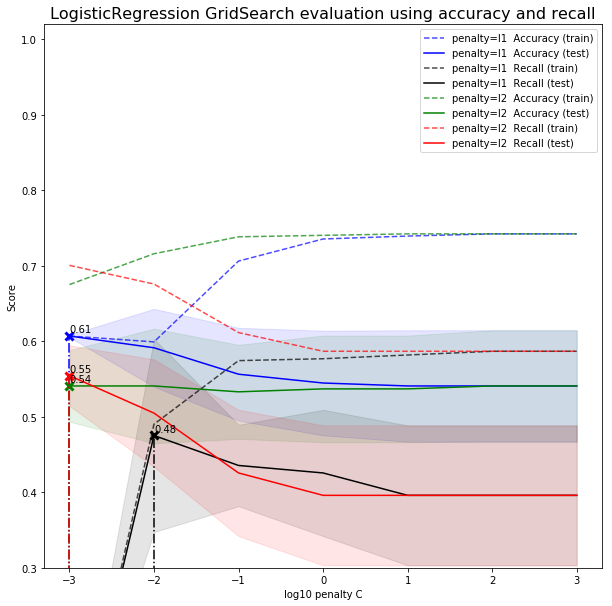

In [19]:
best_clf_lr = GridSearchLogisticRegression(X_1_train,Y_1_train)

When Δt = 1, show the performance of the best tuned model respectively for SVM, RF, LR

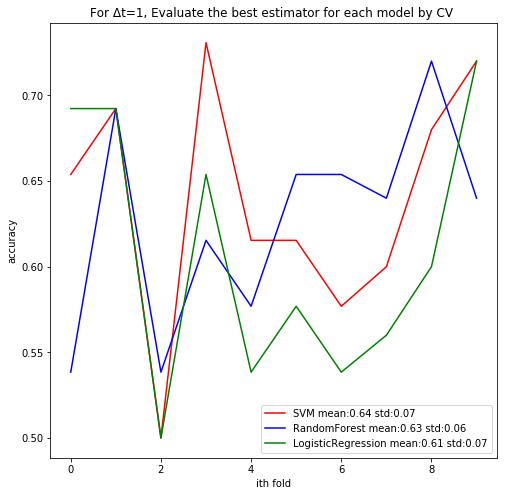

In [20]:
drawBestCLF(best_clf_svm,best_clf_rf,best_clf_lr,skf,X_1_train,Y_1_train,1)

When Δt = 1, from the above chart, the SVM has the best performance

In [21]:
best_clf_1 = best_clf_svm
best_clf_1

Pipeline(memory=None,
     steps=[('preprocess', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

<h1>Δt = 2, find the best model</h1>

First bulid the dataset which is used to fit the model

In [22]:
result = getRelativeChangeInSerachVolume(2)
data = result.merge(spx[['decrease']],left_index=True,right_index=True)
X_2_train, Y_2_train = data.iloc[:,:-1], data['decrease']

When Δt = 2, tune the parameters(C=[0.001, 0.01, 0.1, 1, 10, 100, 1000],kernel=['poly','rbf']) for SVM

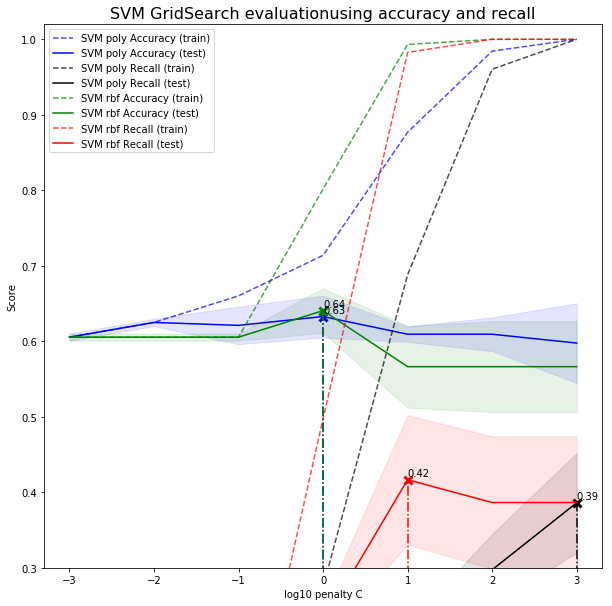

In [23]:
best_clf_svm = GridSearchSVM(X_2_train,Y_2_train)

When Δt = 2, tune the parameters(max_features:['sqrt','None'],min_samples_split:[2,3,4,5]) for RandomForest

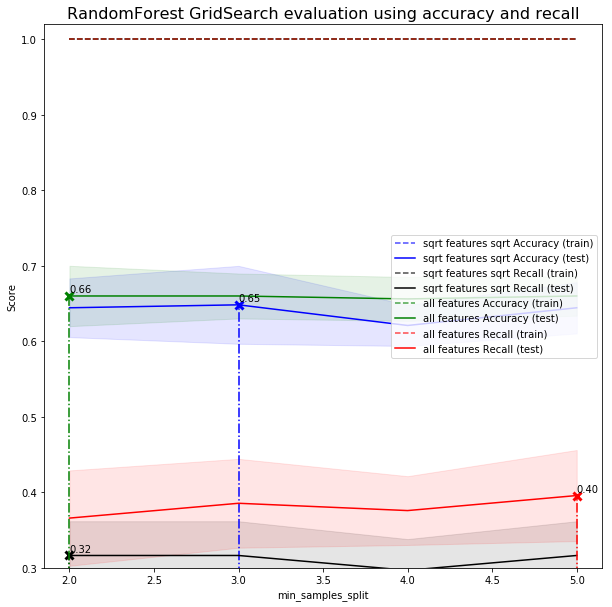

In [24]:
best_clf_rf = GridSearchRandomForest(X_2_train,Y_2_train)

When Δt = 2, tune the parameters(C=[0.001, 0.01, 0.1, 1, 10, 100, 1000],penalty=['l1','l2']) for LogisticRegression

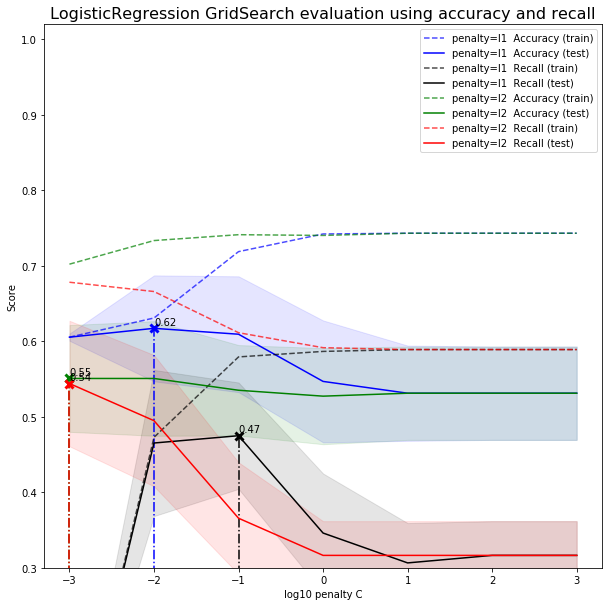

In [25]:
best_clf_lr = GridSearchLogisticRegression(X_2_train,Y_2_train)

When Δt = 2, show the performance of the best tuned model respectively for SVM, RF, LR

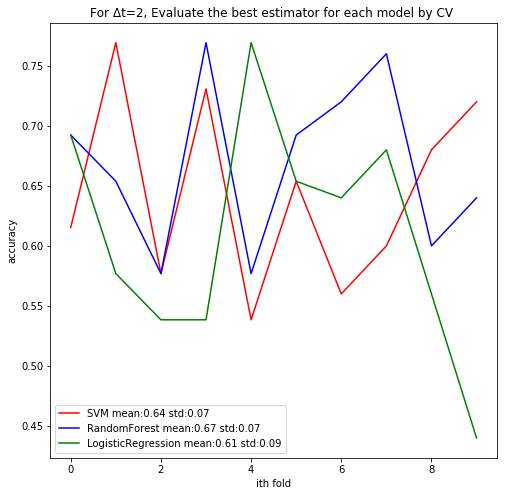

In [26]:
drawBestCLF(best_clf_svm,best_clf_rf,best_clf_lr,skf,X_2_train,Y_2_train,2)

When Δt = 2, from the above chart, the RF has the best performance

In [27]:
best_clf_2 = best_clf_rf
best_clf_2

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

<h1>Δt = 3, find the best model</h1>

First bulid the dataset which is used to fit the model

In [28]:
result = getRelativeChangeInSerachVolume(3)
data = result.merge(spx[['decrease']],left_index=True,right_index=True)
X_3_train, Y_3_train = data.iloc[:,:-1], data['decrease']

When Δt = 3, tune the parameters(C=[0.001, 0.01, 0.1, 1, 10, 100, 1000],kernel=['poly','rbf']) for SVM

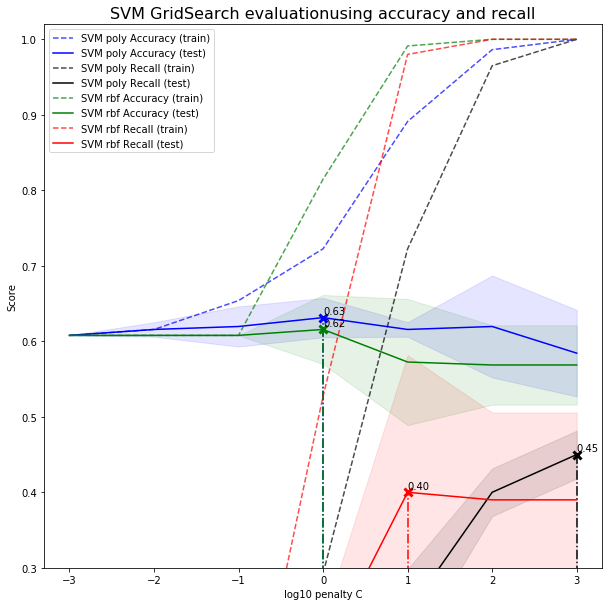

In [29]:
best_clf_svm = GridSearchSVM(X_3_train,Y_3_train)

When Δt = 3, tune the parameters(max_features:['sqrt','None'],min_samples_split:[2,3,4,5]) for RandomForest

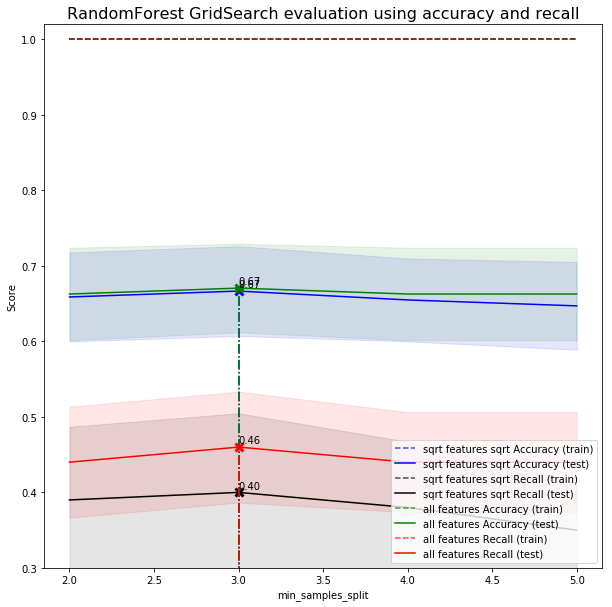

In [30]:
best_clf_rf = GridSearchRandomForest(X_3_train,Y_3_train)

When Δt = 3, tune the parameters(C=[0.001, 0.01, 0.1, 1, 10, 100, 1000],penalty=['l1','l2']) for LogisticRegression

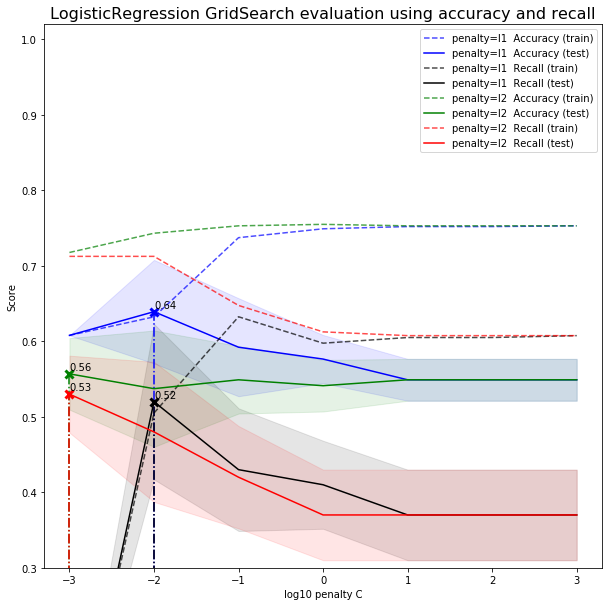

In [31]:
best_clf_lr = GridSearchLogisticRegression(X_3_train,Y_3_train)

When Δt = 3, show the performance of the best tuned model respectively for SVM, RF, LR

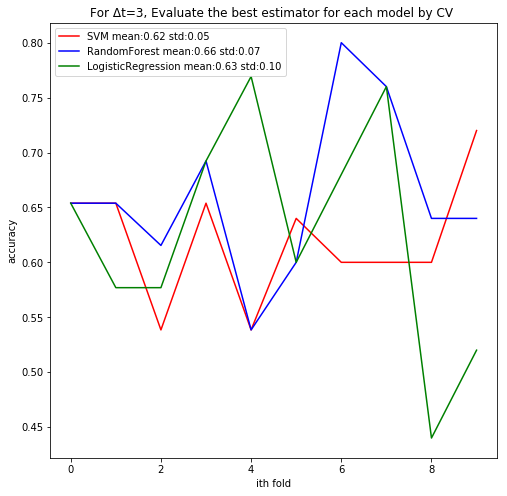

In [32]:
drawBestCLF(best_clf_svm,best_clf_rf,best_clf_lr,skf,X_3_train,Y_3_train,3)

When Δt = 3, from the above chart, the RF has the best performance

In [33]:
best_clf_3 = best_clf_rf
best_clf_3

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

<h1>Δt = 4, find the best model</h1>

First bulid the dataset which is used to fit the model

In [34]:
result = getRelativeChangeInSerachVolume(4)
data = result.merge(spx[['decrease']],left_index=True,right_index=True)
X_4_train, Y_4_train = data.iloc[:,:-1], data['decrease']

When Δt = 4, tune the parameters(C=[0.001, 0.01, 0.1, 1, 10, 100, 1000],kernel=['poly','rbf']) for SVM

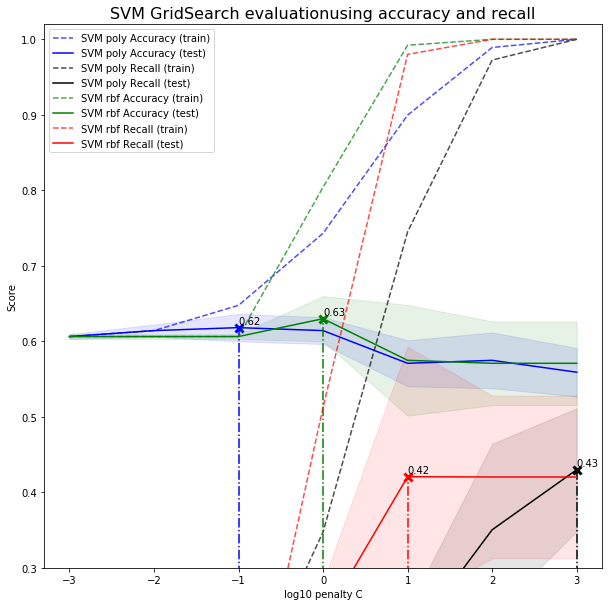

In [35]:
best_clf_svm = GridSearchSVM(X_4_train,Y_4_train)

When Δt = 4, tune the parameters(max_features:['sqrt','None'],min_samples_split:[2,3,4,5]) for RandomForest

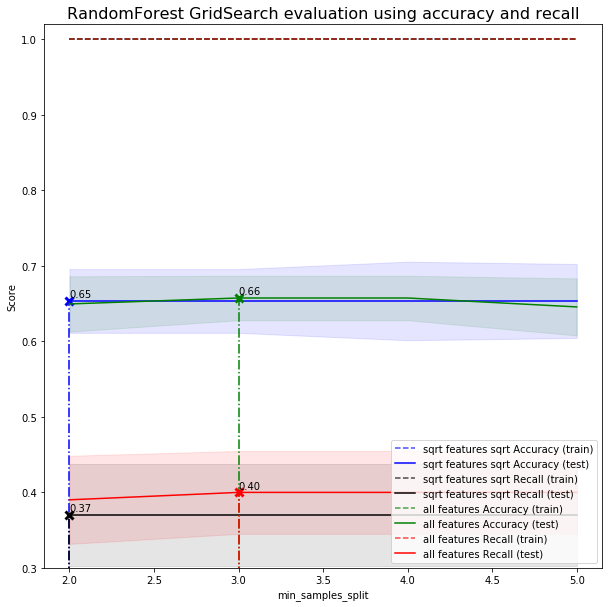

In [36]:
best_clf_rf = GridSearchRandomForest(X_4_train,Y_4_train)

When Δt = 4, tune the parameters(C=[0.001, 0.01, 0.1, 1, 10, 100, 1000],penalty=['l1','l2']) for LogisticRegression

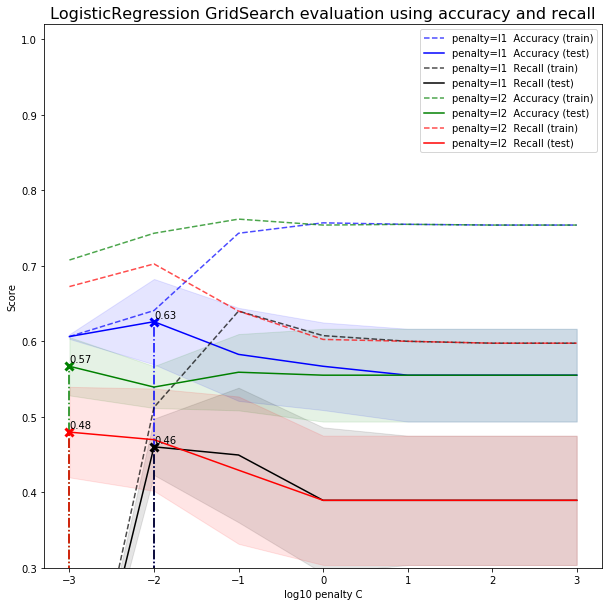

In [37]:
best_clf_lr = GridSearchLogisticRegression(X_4_train,Y_4_train)

When Δt = 4, show the performance of the best tuned model respectively for SVM, RF, LR

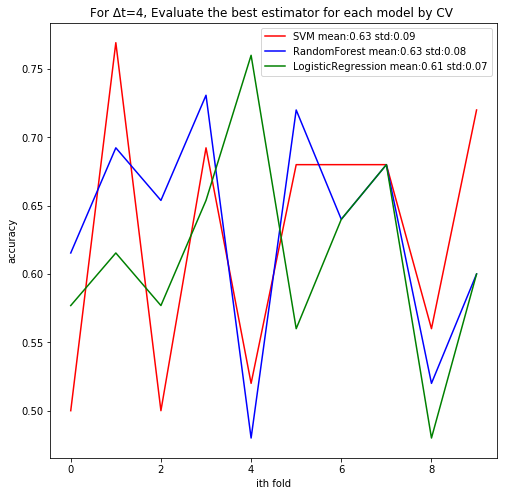

In [38]:
drawBestCLF(best_clf_svm,best_clf_rf,best_clf_lr,skf,X_4_train,Y_4_train,4)

When Δt = 4, from the above chart, the RF has the best performance

In [39]:
best_clf_4 = best_clf_rf
best_clf_4

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

<h1>Up to now, the best model for Δt =1,2,3,4 respectively has been obtained, which is the best?</h1>

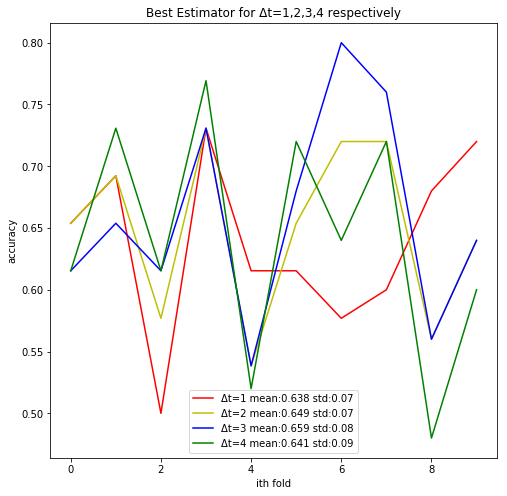

In [40]:
result_1 = cross_val_score(best_clf_1,X_1_train,Y_1_train,cv=skf)
result_2 = cross_val_score(best_clf_2,X_2_train,Y_2_train,cv=skf)
result_3 = cross_val_score(best_clf_3,X_3_train,Y_3_train,cv=skf)
result_4 = cross_val_score(best_clf_4,X_4_train,Y_4_train,cv=skf)
plt.figure(figsize=(8, 8))
plt.title('Best Estimator for Δt=1,2,3,4 respectively')
plt.xlabel('ith fold')
plt.ylabel('accuracy')
plt.plot(range(0,10),result_1,'r-',label="Δt=1 mean:%0.3f std:%0.2f" % (np.mean(result_1),np.std(result_1)))
plt.plot(range(0,10),result_2,'y-',label="Δt=2 mean:%0.3f std:%0.2f" % (np.mean(result_2),np.std(result_2)))
plt.plot(range(0,10),result_3,'b-',label="Δt=3 mean:%0.3f std:%0.2f" % (np.mean(result_3),np.std(result_3)))
plt.plot(range(0,10),result_4,'g-',label="Δt=4 mean:%0.3f std:%0.2f" % (np.mean(result_4),np.std(result_4)))
plt.legend()
plt.show()

From the chart above, Δt = 3 has the best performance

In [41]:
best_clf = best_clf_3
best_clf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

<h1>How well  this model is when Δt = 3</h1>

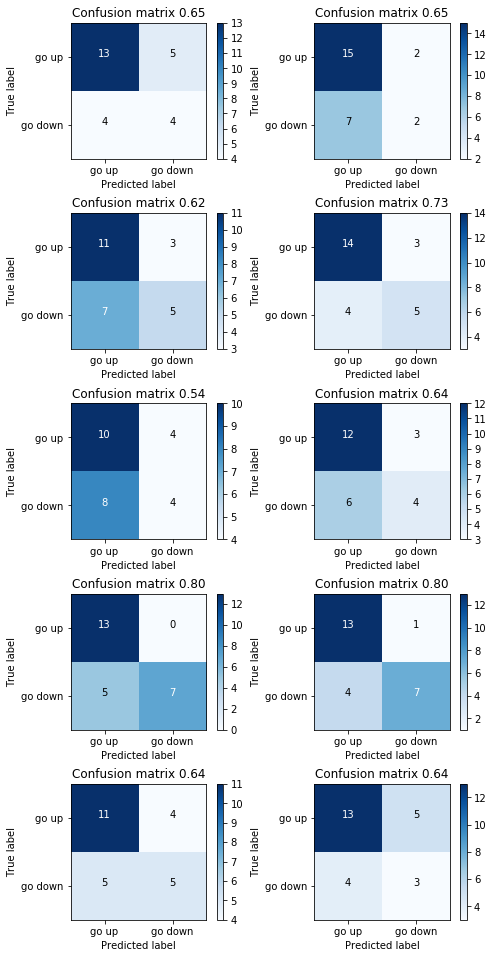

The average accuracy is 0.671 and the std is 0.078


In [42]:
fig1 = plt.figure(num=1, figsize=(8,20))
n_splits = 10
cols = 2
gs = gridspec.GridSpec( n_splits// cols + 1, cols)
gs.update(hspace=0.4)
ax = []
result = []
kf = KFold(n_splits=n_splits,random_state=6)
i = 0
for train,test in kf.split(X_3_train):
    row = (i // cols)
    col = i % cols
    i = i+1
    ax.append(fig1.add_subplot(gs[row, col]))
    plt.sca(ax[-1])
    best_clf.fit(X_3_train.iloc[train],Y_3_train.iloc[train])
    predict_result = best_clf.predict(X_3_train.iloc[test])
    accuracy_rate = accuracy_score(Y_3_train.iloc[test],predict_result)
    result.append(accuracy_rate)
    cnf_matrix = confusion_matrix(Y_3_train.iloc[test],predict_result)
    plot_confusion_matrix(cnf_matrix, classes=['go up','go down'],
                      title='Confusion matrix %0.2f' %accuracy_rate)
plt.show()
print('The average accuracy is %0.3f and the std is %0.3f'%(np.average(result),np.std(result)))